In [73]:
import pandas as pd
import numpy as np

from dateutil.parser import parse
from datetime import datetime
import dateutil.parser

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


import glob
import os
import zipfile

import timeit

import warnings
warnings.filterwarnings('ignore')


## Project Introduction


The nonprofit organization, WomenTechWomenYes (WTWY) has an annual gala at the beginning of the summer each year in which they hope to both to fill their event space with individuals passionate about increasing the participation of women in technology, and to concurrently build awareness and reach.

To this end, the organization plans to place street teams at entrances to subway stations. The street teams collect email addresses and those who sign up are sent free tickets to our gala.

WTWY have now soliticed our involvement as data scientists to utilize publically accessible MTA data to optimize the placement of their street teams such that they can gather the most signatures, ideally from those who will attend the gala and contribute to our cause.
 

## Goals + Methodology

Our primary goal in this presentation is to maximize the number of signatures obtained at subway station entrances/exits via street marketing teams, focusing on those individuals who will attend the gala and contribute to WTWY’s cause.

To do so, we will look at MTA subway data as well as NYC Census data to determine, not just the busiest stations, but the stations with the most value-added individuals considering our prompt above. In addition, we will look at technology companies in the areas near stations to determine best allotment of street marketing team placement. 

## Contraints + Assumptions

Before continuing we did have some constraints on this project. Namely: 

- What is their marketing budget for street teams? (to determine how many stations we can post people at)
- Historical data about their previous collection efforts? (the email mentions they have done collections before...I’d be interested to see the demographic information of those that signed up...I’d also be interested in looking at who actually donated/attended the gala from the sign-ups
- Primary promotional period for conventions? (how long in advance do typical conventions promote their event?)

These constraints led us to a number of assumptions:

- We should target high-income earners with a bachelor’s degree or higher. We assume those with a higher income will be more willing/able to donate.
- While both males and females may be interested in the cause, we should primarily target females considering the company in question
- We should target those working for tech companies in the area
- We should focus on marketing the event in the Spring season leading up to summer (March - May)

## A. Read in All External Files For EDA

To begin, let's read in the relevant files for this project.

In [3]:
# find and bring in all txt files from working directory
extension = 'txt'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [6]:
# export 2019 data into a single CSV file
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "2019_csv.txt", index=False, encoding='utf-8-sig')

In [4]:
# read in 2019 turnstile data
mta_df = pd.read_csv("2019_csv.txt")


In [5]:
# read in zillow property values for NYC
home_df = pd.read_csv('homes.csv')

In [6]:
# read in station zip codes 
zips = pd.read_csv('zips.txt')

## I. Home Values By Zip Code 


While we will certainly need to look at the MTA Turnstile Data in order to determine traffic patterns per station and throughout the week, it is vital that we start with an understand of where affluent potential donors reside in the city.

To do this we pulled a home valuation home report from Zillow to find zip codes with the highest property values.

In [10]:
# get an initial look at the data
home_df.describe()

,"New York, NY - All Homes",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60
count,172,171,171,172,171,171,171,171,171,172,...,171,171,172,171,171,171,172,171,171,171
unique,172,3,2,145,38,71,106,77,56,6,...,2,2,153,49,65,83,117,55,68,90
top,11411,zipcode,All Homes,---,---,---,---,---,---,---,...,---,---,---,--0.3%,--0.7%,---,$1.79,--0.8%,--1.5%,3.0%
freq,1,169,170,25,25,25,25,25,26,167,...,170,170,7,15,9,7,5,10,9,7


In [11]:
# drop unneeded columns
home_df.drop(home_df.columns[4:], axis=1, inplace=True)

In [12]:
# drop unneeded columns
home_df.drop(home_df.columns[1:3], axis=1, inplace=True)

In [13]:
# renamed columns to zip and values
home_df.rename(columns={'New York, NY - All Homes': 'Zip Code', 'Unnamed: 3': 'Value'}, inplace=True)

In [14]:
# test to make sure columns populated appropriately 
home_df.columns

Index(['Zip Code', 'Value'], dtype='object')

In [15]:
home_df.head(5)

,Zip Code,Value
0,Statistic,Zillow Home Value Index
1,Region Name,Current
2,New York,"$676,000"
3,10001,"$1,892,700"
4,10002,"$909,900"


In [16]:
# delete the first three rows so that we only have zips and values
home_df.drop(home_df.index[:3], inplace=True)

In [17]:
# delete all rows with no value
home_df = home_df[home_df.Value != '---']

In [18]:
# parse out $ and convert currency str to float
home_df[home_df.columns[1:]] = home_df[home_df.columns[1:]].replace('[\$,]', '', regex=True,).astype(float)

In [19]:
#sort dataframe for highest values by zip code
home_df.sort_values(by='Value', ascending = False)

,Zip Code,Value
14,10013,2895400.0
9,10007,2545200.0
13,10012,2359700.0
3,10001,1892700.0
15,10014,1737700.0
42,10069,1701300.0
11,10010,1630000.0
12,10011,1585500.0
5,10003,1544000.0
41,10065,1528200.0


### We can see here that the 10 highest valued zip codes are the following: 10013, 10007, 10012, 10001, 10014, 10069, 10010, 10011, 10003, 10065 

## II. Tech Company Presence in New York City

This next section is brief and qualitative. From the source [Built In NYC!](https://www.builtinnyc.com/2016/08/09/nyc-fundings-zipcode-2016)

Here we found a list of NYC's top 10 most funded zip codes. 

The results were as follows: 

Top 10 New York City zip codes by funding
- 10001 (Nomad/Chelsea): $659,233,062  

- 10011 (Chelsea): $585,958,612    

- 10010 (Gramercy): $365,256,465

- 10007 (TriBeCa): $254,099,998

- 10016 (Kips Bay): $185,792,256  

- 10018 (Midtown): $173,110,000

- 10036 (Hell’s Kitchen): $170,800,000

- 10013 (Soho): $155,664,999

- 10012 (Soho): $157,630,108

- 10014 (Meatpacking): $78,100,000  



## III. The Overlap  Between Tech & Wealth

### The overlap of the above two lists is 10013, 10007, 10012, 10001, 10014, 10010, 10011.

With this in mind, we will now look at the (very messy) MTA turnstile data in hopes of finding some value-added stations within these zip codes.

## IV. Diving into the MTA Data

First, let's get a feel for the data and try to determine overall traffic patterns per station before drilling into the minutia. We want to find out the overall top stations by traffic and attempt to cross-reference with the lists of zip codes above in the hopes of finding both high volume stations as well as stations that fit our target demographics.

### Initial Data Formatting + Cleaning


In [23]:
# preview the data 
mta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2653353 entries, 0 to 2653352
Data columns (total 11 columns):
C/A                                                                     object
UNIT                                                                    object
SCP                                                                     object
STATION                                                                 object
LINENAME                                                                object
DIVISION                                                                object
DATE                                                                    object
TIME                                                                    object
DESC                                                                    object
ENTRIES                                                                 int64
EXITS                                                                   int64
dtypes: int64(2), ob

In [25]:
mta_df.describe()

,ENTRIES,EXITS
count,2.653353e+06,2.653353e+06
mean,4.098466e+07,3.366256e+07
std,2.101076e+08,1.943702e+08
min,0.000000e+00,0.000000e+00
25%,3.680650e+05,1.541680e+05
50%,2.245955e+06,1.292873e+06
75%,6.785287e+06,4.638681e+06
max,2.129459e+09,2.124283e+09


In [28]:
#rename and reformat columns for standardization
mta_df.rename(columns = {
    'C/A': 'area',
    'UNIT': 'unit',
    'SCP': 'scp',
    'STATION': 'station',
    'LINENAME': 'linename',
    'DIVISION': 'division',
    'DATE': 'date',
    'TIME': 'time',
    'DESC': 'desc',
    'ENTRIES': 'entries',
    'EXITS                                                               ': 'exits'},
    inplace = True)

In [31]:
# preview the data 
mta_df.head()

,area,unit,scp,station,linename,division,date,time,desc,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,00:00:00,REGULAR,6989774,2370411
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,04:00:00,REGULAR,6989795,2370413
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,08:00:00,REGULAR,6989813,2370436
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,12:00:00,REGULAR,6989924,2370512
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,16:00:00,REGULAR,6990200,2370573


### Entries

In [34]:
# group the dataframe by turnstile identifiers/date columns and aggregate the entry column by taking minumums. 
# Since the entry column tracks cumulative entries, for any given day the total entries should be given by the difference 
# between the min of next day's entry values and the min of this day's entry values.

entries_byDate = mta_df.groupby(['area','unit','scp','station','date']).entries.agg({'min_entries':'min'})
entries_byDate = entries_byDate.reset_index()

entries_byDate['daily_entries'] = entries_byDate.groupby(['area','unit','scp','station']).min_entries.diff().shift(-1)

In [35]:
# set the negative entry values or excessively large entry values to NaN 
# (these are invalid and something went wrong with the cumulative count).

entries_byDate.loc[entries_byDate['daily_entries'] <= 0, 'daily_entries'] = np.nan
entries_byDate.loc[entries_byDate['daily_entries'] > 100000, 'daily_entries'] = np.nan
entries_byDate.head()

,area,unit,scp,station,date,min_entries,daily_entries
0,A002,R051,02-00-00,59 ST,02/23/2019,6955483,694.0
1,A002,R051,02-00-00,59 ST,02/24/2019,6956177,405.0
2,A002,R051,02-00-00,59 ST,02/25/2019,6956582,1355.0
3,A002,R051,02-00-00,59 ST,02/26/2019,6957937,1408.0
4,A002,R051,02-00-00,59 ST,02/27/2019,6959345,1345.0


In [37]:
# plot the total number of entries for the collection period

entries_total = entries_byDate.groupby('station')['daily_entries'].sum()
entries_total.sort_values(ascending=False,inplace=True)
entries_total.head(10)

station
34 ST-PENN STA     13421024.0
GRD CNTRL-42 ST    11567811.0
34 ST-HERALD SQ     9174737.0
23 ST               9062537.0
14 ST-UNION SQ      8283773.0
TIMES SQ-42 ST      7964216.0
42 ST-PORT AUTH     7461316.0
FULTON ST           7421486.0
86 ST               6522669.0
125 ST              6122705.0
Name: daily_entries, dtype: float64

### Exits

This is the same process as the entries code above.

In [39]:
exits_byDate = mta_df.groupby(['area','unit','scp','station','date']).exits.agg({'min_exits':'min'})
exits_byDate = exits_byDate.reset_index()

exits_byDate['daily_exits'] = exits_byDate.groupby(['area','unit','scp','station']).min_exits.diff().shift(-1)

In [40]:
exits_byDate.loc[exits_byDate['daily_exits'] <= 0, 'daily_exits'] = np.nan
exits_byDate.loc[exits_byDate['daily_exits'] > 100000, 'daily_exits'] = np.nan
exits_byDate.head()

,area,unit,scp,station,date,min_exits,daily_exits
0,A002,R051,02-00-00,59 ST,02/23/2019,2359112,220.0
1,A002,R051,02-00-00,59 ST,02/24/2019,2359332,164.0
2,A002,R051,02-00-00,59 ST,02/25/2019,2359496,531.0
3,A002,R051,02-00-00,59 ST,02/26/2019,2360027,565.0
4,A002,R051,02-00-00,59 ST,02/27/2019,2360592,540.0


In [41]:
exits_total = exits_byDate.groupby('station')['daily_exits'].sum()
exits_total.sort_values(ascending=False,inplace=True)
exits_total.head(10)

station
34 ST-PENN STA     12235327.0
GRD CNTRL-42 ST    10194318.0
34 ST-HERALD SQ     9092867.0
14 ST-UNION SQ      7640462.0
TIMES SQ-42 ST      7528638.0
23 ST               6702269.0
42 ST-PORT AUTH     6378715.0
FULTON ST           6284757.0
86 ST               5987315.0
125 ST              5151031.0
Name: daily_exits, dtype: float64

### Overall Traffic


In [44]:
# add the two dataframes together for a sum of traffic over the collection period

df_combined_traffic = entries_total.add(exits_total, fill_value=0)
df_combined_traffic.sort_values(ascending=False,inplace=True)
df_combined_traffic.head(10)

station
34 ST-PENN STA     25656351.0
GRD CNTRL-42 ST    21762129.0
34 ST-HERALD SQ    18267604.0
14 ST-UNION SQ     15924235.0
23 ST              15764806.0
TIMES SQ-42 ST     15492854.0
42 ST-PORT AUTH    13840031.0
FULTON ST          13706243.0
86 ST              12509984.0
125 ST             11273736.0
dtype: float64

Text(0, 0.5, 'Total Ridership')

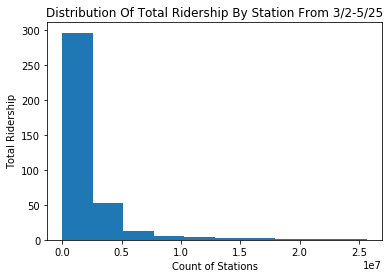

In [52]:
# quick histogram showing that the ditribution of total ridership

plt.hist(df_combined_traffic)

plt.title('Distribution Of Total Ridership By Station From 3/2-5/25')
plt.xlabel('Count of Stations')
plt.ylabel('Total Ridership')

This shows us that there are a very small number of stations with a large total ridership and a ton of stations with much smaller ridership (right tailed distribution).

In [67]:
# create a new variable for the top 10 most trafficked stations 

top_25 = df_combined_traffic.head(25)

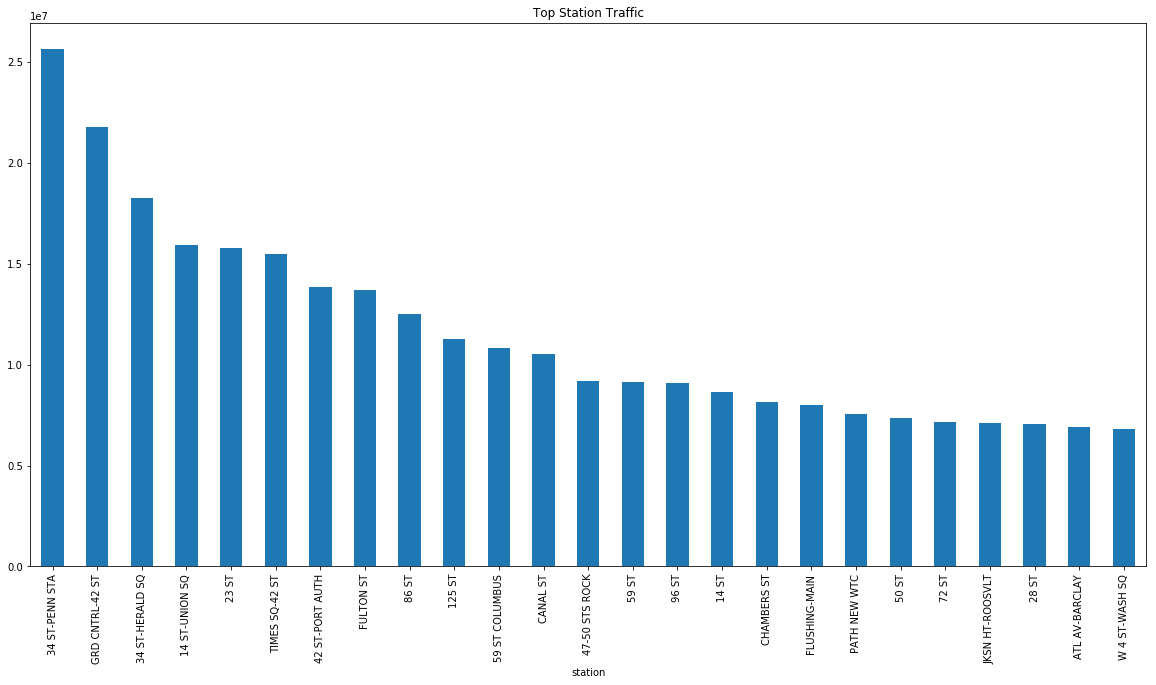

In [122]:
# quick bar plot showing the top 25 most trafficked stations

top_25.plot(kind="bar", figsize=(20,10), title='Top Station Traffic')

plt.savefig("total_traffic.png")


## V. The Overlap Between Tech, Wealth & Stations


We must next plot the intersection between the top zip codes, locations of tech companies and most trafficked stations. 

In [104]:
# first we need to merge the zip code information with our main mta dataframe

mta_df = mta_df.merge(zips, on='station')


In [105]:
#zip_codes with home value > 1.5mil
#and top ten most funded zip codes
potential_zips = [10013, 10007, 10012, 10001, 10014, 10010, 10011]

In [106]:
# stations that are located within the 7 zip codes in the previous cell
potential_stations = mta_df[mta_df['zip_code'].isin(potential_zips)]

In [107]:
# print a list of the unique stations that fall within our target zip codes
prime_stations = potential_stations['station'].unique()

In [108]:
prime_stations

array(['28 ST', '23 ST', 'PRINCE ST', 'CANAL ST', 'CITY HALL',
       'CORTLANDT ST', 'CHAMBERS ST', 'PARK PLACE', '6 AV', '14 ST',
       'W 4 ST-WASH SQ', 'SPRING ST', 'WORLD TRADE CTR',
       "B'WAY-LAFAYETTE", 'CHRISTOPHER ST', '9TH STREET', '14TH STREET',
       'TWENTY THIRD ST', 'THIRTY ST', 'THIRTY THIRD ST', 'PATH WTC 2',
       'FRANKLIN ST', 'HOUSTON ST', '18 ST', 'BROOKLYN BRIDGE',
       'BLEECKER ST', '33 ST', '34 ST-HUDSON YD'], dtype=object)

We see that there is indeed a station list that intersects top zips, and tech companies (in order of most to least traffic): 

### 23 ST (10010), CANAL ST (10013), 14 ST (10011), CHAMBERS ST (10013), 28 ST (10001)

- 23rd is the top trafficked, 3rd most funded, and 7th on home value
- Canal is 2nd in traffic, 8th most funded, top on homes value
- 14th is 3rd in traffic, 2nd most funded, 8th on home value
- Chambers is 4th in traffic, 8th most funded and tops home value (same zip as canal - SHOULD NOT CONSIDER)
- 28th is 5th in traffic, top most funded and 4th in home value

Let's look at those 5 stations in more detail to understand how we should allocate street marketing teams across them.

## VI. The 5 Stations

In [82]:
# filter for our top stations of 23 ST, CANAL ST, 14 ST, 28 ST, CHAMBERS ST

df_top_stations = mta_df.loc[(mta_df['station'] == '23 ST') | (mta_df['station'] == 'CANAL ST') | (mta_df['station'] == '14 ST') | (mta_df['station'] == '28 ST') | (mta_df['station'] == 'CHAMBERS ST')]
 

In [84]:
# convert top stations to datetime
df_top_stations['date'] = pd.to_datetime(df_top_stations['date'])

In [85]:
# add day of the week column
df_top_stations['weekday'] = df_top_stations['date'].dt.dayofweek

In [86]:
# add parsed time column
df_top_stations['parsed_time'] = df_top_stations['time'].apply(parse)


In [87]:
#drop weekends
df_top_stations = df_top_stations[df_top_stations['weekday'].isin([0,1,2,3,4])]

In [89]:
# dataset is cumulative so we are taking the difference between the current and prior collection period
# we are then summing up both the entries and exit differences to get the total in the column

df_top_stations['entries_diff'] = df_top_stations['entries'].diff(1);
df_top_stations['exits_diff'] = df_top_stations['exits'].diff(1);
df_top_stations['total_traffic'] = df_top_stations['entries_diff'] + df_top_stations['exits_diff']

In [90]:
# set the negative entry values or excessively large entry values to NaN 
# these are invalid and something went wrong with the cumulative count).

df_top_stations.loc[df_top_stations['entries_diff'] <= 0.0, 'entries_diff'] = np.nan;
df_top_stations.loc[df_top_stations['entries_diff'] > 10000.0, 'entries_diff'] = np.nan;
df_top_stations.loc[df_top_stations['exits_diff'] <= 0.0, 'exits_diff'] = np.nan;
df_top_stations.loc[df_top_stations['exits_diff'] > 10000.0, 'exits_diff'] = np.nan;
df_top_stations.loc[df_top_stations['total_traffic'] <= 0.0, 'total_traffic'] = np.nan;
df_top_stations.loc[df_top_stations['total_traffic'] > 100000.0, 'total_traffic'] = np.nan;

In [91]:
# calculate total traffic across stations
total_by_station = df_top_stations.groupby(by='station', as_index=False).sum()[['station','total_traffic']].sort_values('total_traffic', ascending=False)

In [92]:
# find the weekly traffic 
total_by_station['weekly_traffic'] = total_by_station['total_traffic']/6

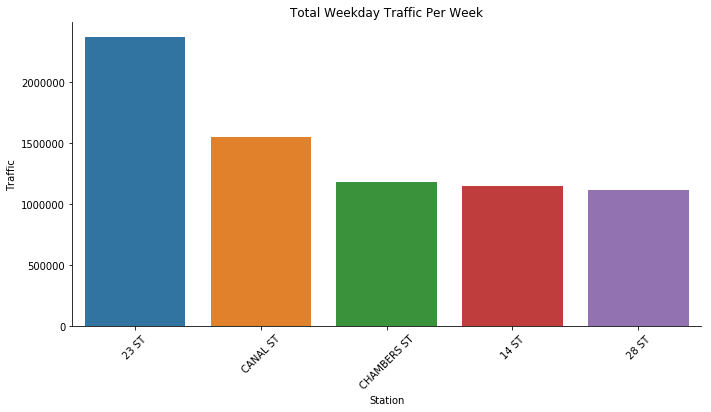

In [121]:
# plot weekly traffic in total
weekdays = sns.catplot('station', 'weekly_traffic', data = total_by_station, kind = 'bar', aspect = 2)
plt.xticks(rotation=45)
plt.xlabel('Station')
plt.ylabel('Traffic')
plt.title("Total Weekday Traffic Per Week")

plt.savefig("weekly_traffic.svg")

In [94]:
# create a list parsed by time for our five candidate stations

top_stations_lst = ['23 ST',
                   'CANAL ST',
                   'CHAMBERS ST',
                   '14 ST',
                   '28 ST']

top_stations = df_top_stations[df_top_stations['station'].isin(top_stations_lst)]
top_stations = top_stations.groupby(by=['station', 'parsed_time'], as_index=False).sum()[['station', 'parsed_time','total_traffic']]
top_stations.set_index('parsed_time', drop=True, inplace=True)
top_stations = top_stations.groupby(by=['station']).resample('4H').mean()
top_stations = top_stations.reset_index()

In [95]:
top_stations

,station,parsed_time,total_traffic
0,14 ST,2019-07-07 00:00:00,1.976580e+05
1,14 ST,2019-07-07 04:00:00,7.622231e+03
2,14 ST,2019-07-07 08:00:00,3.642438e+04
3,14 ST,2019-07-07 12:00:00,3.899742e+05
4,14 ST,2019-07-07 16:00:00,2.725895e+05
5,14 ST,2019-07-07 20:00:00,5.577180e+04
6,23 ST,2019-07-07 00:00:00,6.500697e+05
7,23 ST,2019-07-07 04:00:00,1.606138e+04
8,23 ST,2019-07-07 08:00:00,3.112545e+04
9,23 ST,2019-07-07 12:00:00,5.328437e+05


In [96]:
# create a list parsed by weekday for our candidate stations

stations_by_weekday = df_top_stations[df_top_stations['station'].isin(top_stations_lst)]
stations_by_weekday = stations_by_weekday.groupby(by=['station', 'weekday'], as_index=False).sum()[['station', 'weekday','total_traffic']]
stations_by_weekday

,station,weekday,total_traffic
0,14 ST,0,1185275.0
1,14 ST,1,1400482.0
2,14 ST,2,1434811.0
3,14 ST,3,1455655.0
4,14 ST,4,1407058.0
5,23 ST,0,3313863.0
6,23 ST,1,2789676.0
7,23 ST,2,2772253.0
8,23 ST,3,2778467.0
9,23 ST,4,2546624.0


In [97]:
# rename labels by day of week

stations_by_weekday.loc[stations_by_weekday['weekday'] == 0, 'label'] = 'Monday'
stations_by_weekday.loc[stations_by_weekday['weekday'] == 1, 'label'] = 'Tuesday'
stations_by_weekday.loc[stations_by_weekday['weekday'] == 2, 'label'] = 'Wednesday'
stations_by_weekday.loc[stations_by_weekday['weekday'] == 3, 'label'] = 'Thursday'
stations_by_weekday.loc[stations_by_weekday['weekday'] == 4, 'label'] = 'Friday'

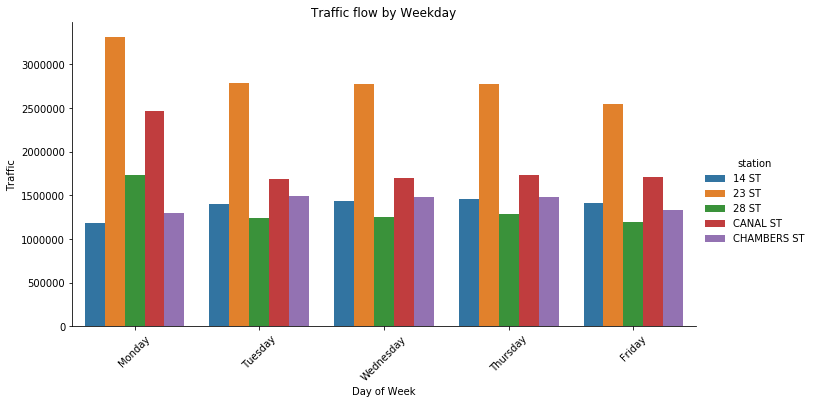

In [120]:
# plot traffic flow by weekday

weekday_bar = sns.catplot('label', 'total_traffic', hue ='station', kind = 'bar', data = stations_by_weekday, aspect = 2)
plt.xticks(rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Traffic')
plt.title('Traffic flow by Weekday')

plt.savefig("weekday_+traffic.png")

In [99]:
#rename time labels for cleanliness

top_stations.loc[top_stations['parsed_time'] == '00:00:00', 'label'] = '8pm-12am'
top_stations.loc[top_stations['parsed_time'] == '04:00:00', 'label'] = '12am-4am'
top_stations.loc[top_stations['parsed_time'] == '08:00:00', 'label'] = '4am-8am'
top_stations.loc[top_stations['parsed_time'] == '12:00:00', 'label'] = '8am-12pm'
top_stations.loc[top_stations['parsed_time'] == '16:00:00', 'label'] = '12pm-4pm'
top_stations.loc[top_stations['parsed_time'] == '20:00:00', 'label'] = '4pm-8pm'

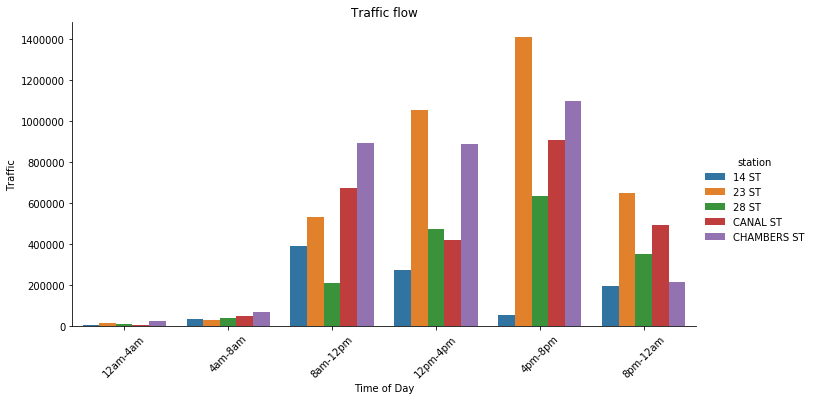

In [119]:
# plot traffic flow by time of day

order = ['12am-4am', '4am-8am', '8am-12pm', '12pm-4pm', '4pm-8pm', '8pm-12am']

flow_bar = sns.catplot('label', 'total_traffic', hue ='station', kind = 'bar', data = top_stations, aspect = 2, order=order)
plt.xticks(rotation=45)
plt.xlabel('Time of Day')
plt.ylabel('Traffic')
plt.title("Traffic flow")

plt.savefig("hourly_traffic.png")

## VII. Recommendations

Based on the above chart, we can draw some conclusions about where to staff street marketing teams for this event.

We recommend that WTWY staff street marketing team in the following:

- Between 4pm and 8pm at 23rd St (highest volume)
- Between 4pm and 8pm at Canal St (most affluent area)
- Between 4pm and 8pm at 28th (most tech investment/funded)

Between the days, there is a highest volume of traffic on mondays but the difference isn't substantial so we will staff marketing teams across the week.

However, the recommendation is not cut and dry and I would recommend doing some A/B testing with the marketing team to dial in placement across the collection period for both time and place.

 